# CS4487 Machine Learning | City University of Hong Kong
## Group Assignment - until 2019.12.13
- Tim Löhr       , EID: 40126684 
- Timo Bohnstedt , EID:
- Karina         , EID:

In [1]:
import os
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import genfromtxt
from keras import regularizers
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import load_model
from keras.models import Model
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from IPython.display import Image
%matplotlib inline

Using TensorFlow backend.


In [2]:
# cifar10 category label name
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

In [3]:
# functions
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [4]:
# get data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_pred = np.load("data/y_test.npy")

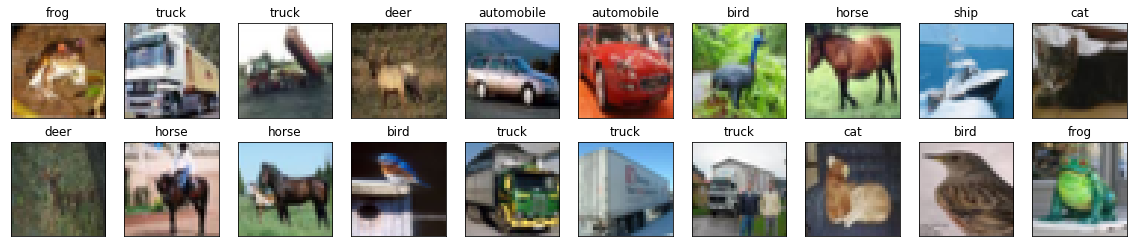

In [5]:
# show imgs
fig = plt.figure(figsize=(20, 4))

for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(x_train[:20][i], cmap='gray')
    ax.set_title(cifar10_labels[y_train[:20][i].item()])

In [6]:
#normalization with z score
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_pred = x_pred.astype('float32')

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
x_pred = (x_pred-mean)/(std+1e-7)

In [7]:
# output vector in a matrix with binary signal values 
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

In [8]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

In [9]:
# define model

weight_decay = 1e-4
datagen.fit(x_train)
model = Sequential()
       

model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=x_train.shape[1:],kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)       

In [10]:
# load or train model

exists = os.path.isfile('model.h5')
if exists:
    #with open('model.json', 'r') as f:
      #  model = model_from_json(f.read())
    model.load_weights('model.h5')
    opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
else:   
    batch_size = 64
    opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                        steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                        verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])   
    model_json = model.to_json()
    with open('model.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights('model.h5')

In [ ]:
#Evaluate    
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=128, verbose=1) 
test_loss = round(test_loss,2)
test_acc = round(test_acc,2)
print('The Test acc from our model is {} while we have a test loss of {}'.format(test_acc, test_loss))
print(test_acc)

In [ ]:
# Predict
'''
dont work?
header = 'Index,Category'
y_pred = model.predict(x_pred, batch_size=128, verbose=1)
y_pred_results = [np.argmax(x) for x in y_pred]
header = 'Index,Category'
np.savetxt('result.csv',np.column_stack((np.arange(0,12000), y_pred_results)), delimiter=',', fmt='%s',header=header,comments='')
'''


y_pred = model.predict(x_pred, batch_size=128, verbose=1)
y_pred_results = [np.argmax(x) for x in y_pred]

np.savetxt('result.csv',np.column_stack((np.arange(0,12000), y_pred_results)), delimiter=',', fmt='%s',header=header,comments='')

In [11]:
# layer name and the shape of the filters in the layer.
for layer in model.layers:
    if 'conv' not in layer.name:
        continue
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d_1 (3, 3, 3, 64)
conv2d_2 (3, 3, 64, 64)
conv2d_3 (3, 3, 64, 128)
conv2d_4 (3, 3, 128, 128)
conv2d_5 (3, 3, 128, 256)
conv2d_6 (3, 3, 256, 256)
conv2d_7 (3, 3, 256, 256)
conv2d_8 (3, 3, 256, 512)
conv2d_9 (3, 3, 512, 512)
conv2d_10 (3, 3, 512, 512)
conv2d_11 (3, 3, 512, 512)
conv2d_12 (3, 3, 512, 512)
conv2d_13 (3, 3, 512, 512)


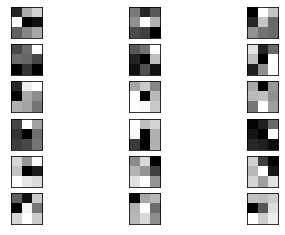

In [19]:
# visualize the filters
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(3):
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
plt.show()

In [12]:
# layer names and the shape of the feature maps in the layer.
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

0 conv2d_1 (None, 32, 32, 64)
4 conv2d_2 (None, 32, 32, 64)
8 conv2d_3 (None, 16, 16, 128)
12 conv2d_4 (None, 16, 16, 128)
16 conv2d_5 (None, 8, 8, 256)
20 conv2d_6 (None, 8, 8, 256)
24 conv2d_7 (None, 8, 8, 256)
28 conv2d_8 (None, 4, 4, 512)
32 conv2d_9 (None, 4, 4, 512)
36 conv2d_10 (None, 4, 4, 512)
40 conv2d_11 (None, 2, 2, 512)
44 conv2d_12 (None, 2, 2, 512)
48 conv2d_13 (None, 2, 2, 512)


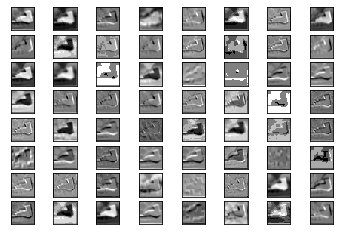

In [18]:
# visualize the feature maps
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
img = x_pred[0:1]
feature_maps = model.predict(img)
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray', aspect='equal')
        ix += 1
# show the figure
plt.show() 